<a href="https://colab.research.google.com/github/JadeArpaliangeas/Test-repo/blob/master/projet_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some PyTorch Optimization Methods

## Instructions

This exam aims at evaluating your understanding and skills in implementing optimization algorithms in PyTorch. Specifically, let us consider methods that correspond to the following Ordinary Differential Equations (ODEs):

$$
x'(t) = -\nabla f(x(t)), \quad y'(t) = -\nabla^2 f(y(t))^{-1} \nabla f(y(t))
$$

We focus exclusively on a function $f: \mathbb{R}^d \rightarrow \mathbb{R}$ defined as
$$
f(\mathbf{x}) = \frac{1}{2} \langle A\mathbf{x}, \mathbf{x} \rangle + \exp(\|\mathbf{x}\|_2) + \sum_{i=1}^{d} \mathbf{x}_i,
$$

where $\mathbf{x} \in \mathbb{R}^d$ and $A$ is a given $d \times d$ matrix. The term $\frac{1}{2} \langle A\mathbf{x}, \mathbf{x} \rangle$ represents a quadratic form, which is convex when the matrix $A$ is positive definite. The term $\exp(\|\mathbf{x}\|_2)$ is the exponential of the Euclidean norm of $ \mathbf{x}$, which is strictly convex. Lastly, $\sum_{i=1}^{d} \mathbf{x}_i$ is the sum of the elements of $\mathbf{x}$, which adds a linear component to the function. The interplay of these terms presents an interesting challenge for optimization algorithms, particularly in the presence of the non-linear exponential term.


**Please read each question carefully and complete the tasks. Implement your solutions in a Google Colab notebook. Once you have completed the exercises, make sure to share the URL of your Google Colab notebook with us.**

**IMPORTANT Requirement:**

1. Make sure to set your Colab notebook sharing settings to 'Anyone with the link can view' before submitting the URL.

2. Don't work on the notebook you've been given, but make a copy and then create your own share link.
  
3. Clearly comment your code to explain the logic behind your implementation steps.

In [1]:
import torch
from torch.autograd import grad
from torch.autograd.functional import jacobian
import matplotlib.pyplot as plt
import numpy as np
import time
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

## Question 1: Implementing the function


$f(\mathbf{x}) = \frac{1}{2} \langle A\mathbf{x}, \mathbf{x} \rangle + \exp(\|\mathbf{x}\|_2) + \sum_{i=1}^{d} \mathbf{x}_i$, where $d$ is the dimension of the vector $\mathbf{x}$.

1. Implement a PyTorch function named `f(x, A)` that computes the function $f$.

In [9]:
def f(x, A):
    matrix_term = 0.5 * torch.matmul(torch.matmul(A, x).view(1, -1), x.view(-1, 1)).item()
    exp_term = torch.exp(torch.norm(x)).item()
    linear_term = torch.sum(x).item()

    return matrix_term + exp_term + linear_term

In [24]:
def f(x, A):
    matrix_term = 0.5 * torch.matmul(torch.matmul(A, x).view(1, -1), x.view(-1, 1))
    exp_term = torch.exp(torch.norm(x))
    linear_term = torch.sum(x)

    return matrix_term + exp_term + linear_term

## Question 2: Implementing Gradient Descent (GD) as an Approximation to the ODE $x'(t)$

Your task is to implement Gradient Descent (GD) as an approximation to the Ordinary Differential Equation (ODE) $x'(t) = -\nabla f(x(t))$. This ODE characterizes the continuous-time dynamics of optimizing the function $f$.

The curve is approximated by a sequence
$$\frac{x_{k+1}-x_k}{\delta}=-\nabla f(x_k), k\geq 0,$$
where $\delta>$ is a time increment parameter.

1. Write a function named `gd_optimization` to perform GD optimization. The function signature should be as follows:
    ```python
    def gd_optimization(f, x_init, A, lr, max_iter):
        # your code here
    ```
    - **f**: The objective function to be minimized, specified as a callable function.
    - **x_init**: The initial point for the optimization, specified as a PyTorch tensor of shape \( (d, ) \).
    - **A**: The coefficient matrix in the least squares function, specified as a PyTorch tensor of shape \( (d, d) \).
    - **lr**: The learning rate, specified as a float.
    - **max_iter**: The maximum number of iterations, specified as an integer.

    Provide comprehensive comments to clarify each implementation step.

    Hint : you can use `torch.autograd.grad`.

---


In [25]:

def gd_optimization(f, x_init, A, lr, max_iter):
    x = torch.clone(x_init).requires_grad_(True)
    losses = []

    for i in range(max_iter):
        loss = f(x, A)
        losses.append(loss.item())  # Use item() to get the scalar value

        # Compute the gradient using torch.autograd.grad
        grad_values = torch.autograd.grad(loss, x)[0]

        # Update x using gradient descent
        x.data -= lr * grad_values.data

    return losses


## Question 3: Implementing Newton's Method

Implement Newton's optimization algorithm as a discretization of the ODE $ y'(t) $. The curve is approximated by a sequence
$$\frac{y_{k+1}-y_k}{\delta}=-\nabla^2f(x_k)^{-1}\nabla f(y_k), \:k\geq 0,$$
where $\delta>$ is a time increment parameter.
1. Write a function named `newton_optimization(f, x_init, A, lr, max_iter)` to perform Newton's optimization.
2. Provide comments detailing how you calculate the Hessian matrix and how it relates to the ODE $ y'(t) $.

Hint : you can use `torch.autograd.functional.jacobian` and `torch.autograd.grad`.




In [35]:
def newton_optimization(f, x_init, A, lr=1.0, max_iter=100):
    x = torch.clone(x_init).requires_grad_(True)
    losses = []

    for i in range(max_iter):
        loss = f(x, A)
        losses.append(loss.item())

        # Compute the gradient using torch.autograd.grad
        grad_values = torch.autograd.grad(loss, x, create_graph=True)[0]

        # Initialize the Hessian matrix
        hessian_matrix = torch.zeros((x.size(0), x.size(0)), dtype=x.dtype)

        # Compute the Hessian matrix
        for j in range(x.size(0)):
            # Compute the j-th column of the Hessian matrix
            hessian_column = torch.autograd.grad(grad_values[j], x, retain_graph=True, create_graph=True)[0]
            hessian_matrix[:, j] = hessian_column

        # Attempt to invert the Hessian matrix
        try:
            hessian_inv = torch.inverse(hessian_matrix)
        except RuntimeError as e:
            print(f"An error occurred while inverting the Hessian at iteration {i+1}: {e}")
            break

        # Update the parameters using Newton's method
        x.data -= lr * torch.matmul(hessian_inv, grad_values.data)

    return losses


In [36]:
newton_optimization(f, x_init, A, lr=1.0, max_iter=100)

[1.2270729905669735,
 -1.3256193824046596,
 -6.217975314677158,
 -6.742661099576883,
 -6.7558078904741885,
 -6.755819287439934,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.755819287449135,
 -6.7558192

## Question 4: Performance Comparison

1. Compare the performance of your GD and Newton's method implementations. Plot the loss over iterations for each method.  

In [37]:
def plot_loss_over_iterations(losses_dict, title):
    plt.figure(figsize=(12, 8))

    for label, losses in losses_dict.items():
        plt.plot(losses, label=label, marker='o' if 'Newton' in label else 'x', linestyle='-' if 'Newton' in label else '--')

    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.yscale('symlog')
    plt.show()

In [38]:
# Initial point
d = 50
A = torch.randn((d,d))/d
x_init = torch.randn(d)/d

In [39]:
f(x_init,A)

tensor([[1.2467]])

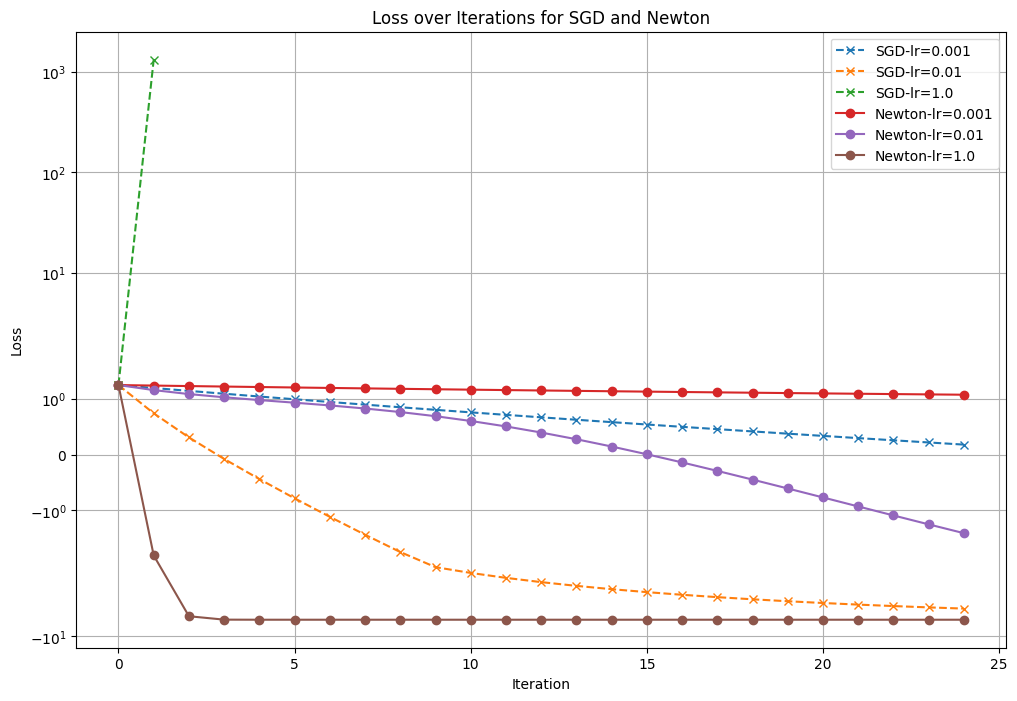

In [40]:
# Learning rates to experiment with
lrs_gd = [0.001,0.01, 1.0]
lrs_newton = [0.001, 0.01, 1.0]


# Run Newton's and SGD optimization
losses = {}
for lr in lrs_gd:
    losses[f'SGD-lr={lr}'] = gd_optimization(f, x_init, A, lr=lr, max_iter=25)
for lr in lrs_newton:
    losses[f'Newton-lr={lr}'] = newton_optimization(f, x_init, A, lr=lr, max_iter=25)



# Plot the losses
plot_loss_over_iterations(losses, title='Loss over Iterations for SGD and Newton')



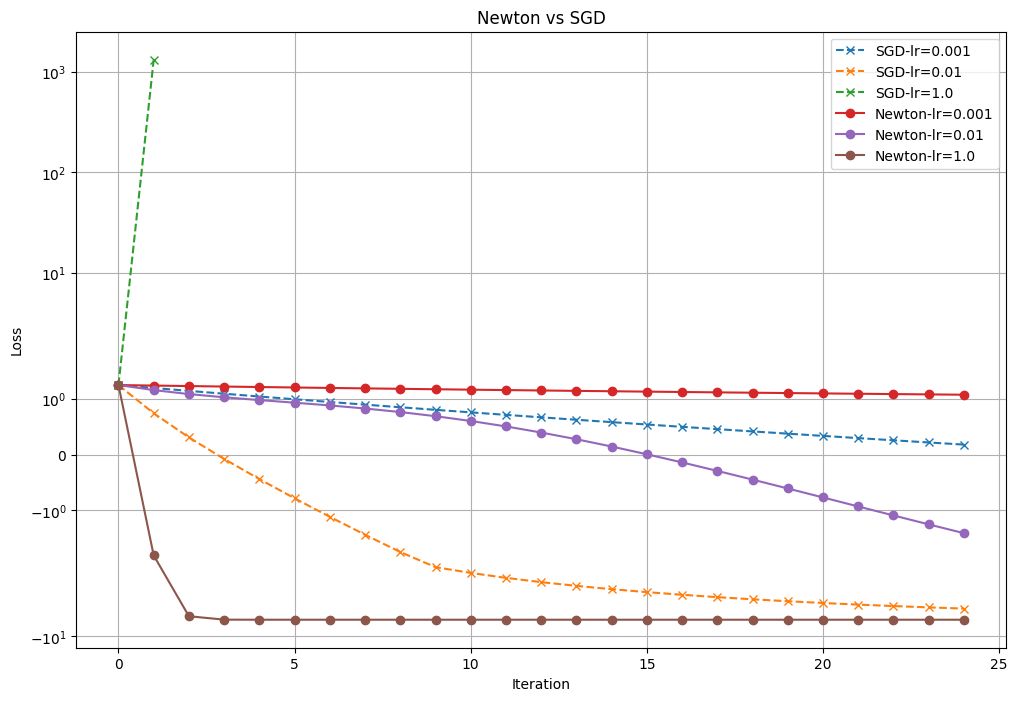

In [41]:
# Plot the loss over iterations for different learning rates
plot_loss_over_iterations(losses, 'Newton vs SGD')